# Support Vector Machines

In this section of the assignment, you will get to implement Support Vector Machines which are among the best (and many believe are indeed the best) “off-the-shelf” supervised learning algorithm.

This section is further divided into 3 subsections.


*   In the first subsection, you will work on a synthetic dataset and visualize the boundary predicted by SVM. You will also vary the value of C-parameter and see how the decision boundary changes. **Please note that you cannot use inbuilt sklearn function for SVM in this sub-section**. You can only use a QCQP (Quadratically Constrained Quadratic Program) solver like CVXPY. 

  References which you may find helpful for this subsection: 
  
  1.   https://www.cvxpy.org/
  2.   https://www.cvxpy.org/examples/basic/quadratic_program.html

  Note that in this section you are expected to show how you derived the Quadratically Constrained form(which can be passed into the solver) from the basic principles of SVM algorithm
*  In the next subsection you will use be using the famous MNIST dataset to explore various kernels and report the results. **Please note you may use inbuilt sklearn SVM functions in this subsection**


In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

## Subsection 1

In [2]:
# Feel free to use this helper function to visualize 2D points X with labels +1 or -1
def plot_points(X, Y):
    reds = []
    blues = []
    for i in range(Y.shape[0]):
        if Y[i] == 1:
            reds.append(X[i])
        else:
            blues.append(X[i])
    reds = np.array(reds)
    blues = np.array(blues)
    plt.scatter(reds[:, 0], reds[:, 1], c = 'r')
    plt.scatter(blues[:, 0], blues[:, 1], c = 'b')

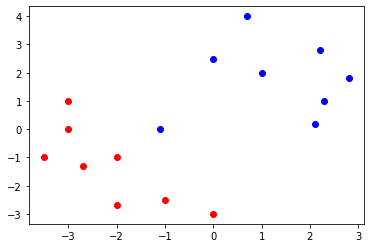

In [3]:
# Create Synthetic Data and visualize the points
X = np.array([[-3.5, -1], [-3, 0], [-3, 1], [-2.7, -1.3], [-2, -1],
        [-2, -2.7], [-1, -2.5], [0, -3], [-1.1, 0], [0, 2.5], [1, 2],
        [0.7, 4], [2.1, 0.2], [2.3, 1], [2.8, 1.8], [2.2, 2.8]])
y = np.array([1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1])

plot_points(X, y)
plt.show()

### Maximum Margin Classifier

A Maximum Margin Classifier creates a linear decision boundary between special data-points (called the support vectors) so that the margin from either of them is maximized.

In the next cell you are required to derive the Quadratic Constrained Quadratic form of SVM **without soft constraints** from the basic principles. Start with the idea that SVM tries to maximize the margin and then derive the form which you can feed to the solver.

Please print the values of w, b. 

**Note: You are also required to upload a page of the derivation. You may also type it in markdown here.**

**Note: You cannot use sklearn SVM functions here.**

**Explanation**

Say we have labelled (two-class) data-points $(\mathbf{x}_i, y_i)$. We wish to separate them using a linear decision boundary. This decision boundary can be parameterized by $\mathbf{w}$ (having the same number of elements as $\mathbf{x}_i$ values do) and a bias $b$ (so that we allow the decision boundary to _not_ be anchored to the origin). Therefore, the decision boundary is given by

$$ f(\mathbf{x}_i; \mathbf{w}, b) = \mathbf{w}^\top \mathbf{x}_i - b = 0 $$

We'd want a point to be as distant from this boundary as possible. Therefore, we define two _parallel_ lines to this (called as the margins) and define them with the equations

$$ \mathbf{w}^\top \mathbf{x} - b = 1 $$

If the LHS is greater than $1$, then the class is $\omega_1$. For the second margin, we have

$$ \mathbf{w}^\top \mathbf{x} - b = -1 $$

If the LHS is less than $-1$, then the class is $\omega_{-1}$. We want to **maximize** the distance (gap) between the margins. For this, we need to first find the length of the gap between the margins. Pick a point $\mathbf{x}_0$ on the second margin $ \mathbf{w}^\top \mathbf{x} - b = -1 $. This means $ \mathbf{w}^\top \mathbf{x}_0 - b = -1 $. Note that the perpendicular unit vector to this line (margin) will be $\mathbf{w}/\left \| \mathbf{w} \right \|$. From $\mathbf{x}_0$, if we travel along this perpendicular vector for $r$ units (let $r$ be the perpendicular distance between the margins), we must reach the first margin given by $ \mathbf{w}^\top \mathbf{x} - b = 1 $. This point (which lies on this first margin) will be $\mathbf{x}_0 + \frac{\mathbf{w}}{\left \| \mathbf{w} \right \|} r$. Substituting this in the second margin and solving for $r$ gives

$$ \mathbf{w}^\top \left ( \mathbf{x}_0 + \frac{\mathbf{w}}{\left \| \mathbf{w} \right \|} r \right ) - b = 1 
\Rightarrow \left ( \mathbf{w}^\top \mathbf{x}_0 - b \right ) + \frac{\mathbf{w}^\top \mathbf{w}}{\left \| \mathbf{w} \right \|} r = 1
\Rightarrow -1 + \frac{\left \| \mathbf{w} \right \|^2}{\left \| \mathbf{w} \right \|} r = 1
\Rightarrow r = \frac{2}{\left \| \mathbf{w} \right \|} $$

We need to **maximize** $r$. In order to do that, we can simply minimize $\left \| \mathbf{w} \right \|$. But note that we cannot have the trivial solution of $\mathbf{w} = \mathbf{0}$ (it'll not be a boundary dependent on data at all!). Additionally, we have constraints _from the data points_ as $\mathbf{w}^\top \mathbf{x}_i - b \ge 1$ (if $y_i = 1$: the sample belongs to $\omega_1$) and $\mathbf{w}^\top \mathbf{x}_i - b \le -1$ (if $y_i = -1$: the sample belongs to $\omega_{-1}$).

Therefore, the problem reduces to: _Minimizing_ $\left \| \mathbf{w} \right \|$, _subjected to_ $y_i \left (\mathbf{w}^\top \mathbf{x}_i - b \right ) \ge 1$

Use [cvxpy](https://www.cvxpy.org/) to find the optimal $\mathbf{w}$ and $b$

In [4]:
# Extract shapes
N, d = X.shape
w = cp.Variable(d)
b = cp.Variable(1)
# All constraints (for all points)
constraints = [y[i] * (w.T @ X[i, :] - b) >= 1 for i in range(N)]
obj = cp.Minimize(cp.norm(w))   # Minimize the norm of w
prob = cp.Problem(obj, constraints) # Define problem
result = prob.solve()   # Solve for w and b
print(f"w: {w.value}, b: {b.value}")

w: [-1.73913043 -1.30434783], b: [2.91304348]


In the next cell you are required to visualize the boundary predicted by the solver. You may want to revise up on how to plot the a line given w, b. Please plot w vector as well as the margin lines

You may want to create a function to plot the line of separation as you would require this frequently in the subsequent parts of the assignment.

In [5]:
# Function
def svm_db(x_min, x_max, y_min, y_max, w=w, b=b, set_lim=True):
    # Decision boundary
    y_x_db = lambda x_val: (b.value - 
        w.value[0] * x_val)/w.value[1]
    # Margin (+1 side)
    y_x_mp1 = lambda x_val: (1 + b.value - 
        w.value[0] * x_val)/w.value[1]
    # Margin (-1 side)
    y_x_mn1 = lambda x_val: (b.value - 1 -
        w.value[0] * x_val)/w.value[1]
    plt.plot([x_min, x_max], [y_x_db(x_min), y_x_db(x_max)], 'g-')
    plt.plot([x_min, x_max], [y_x_mp1(x_min), y_x_mp1(x_max)], 'r--')
    plt.plot([x_min, x_max], [y_x_mn1(x_min), y_x_mn1(x_max)], 'b--')
    if set_lim:
        plt.xlim([x_min - 0.2, x_max + 0.2])
        plt.ylim([y_min - 0.2, y_max + 0.2])

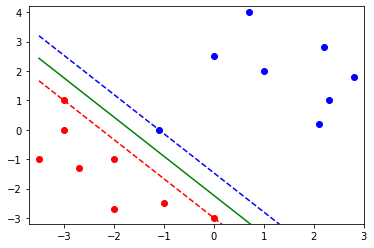

In [6]:
# Write your code here
plot_points(X, y)
# Show the decision boundary
x_min = float(np.min(X[:, 0]))
x_max = float(np.max(X[:, 0]))
y_min = float(np.min(X[:, 1]))
y_max = float(np.max(X[:, 1]))
# Red: +1, Blue: -1, Green: 0 (decision boundary)
svm_db(x_min, x_max, y_min, y_max)
plt.show()

Notice that there are _exactly_ three lagrangian multipliers (KKT actually) that have the highest weight in the constraints

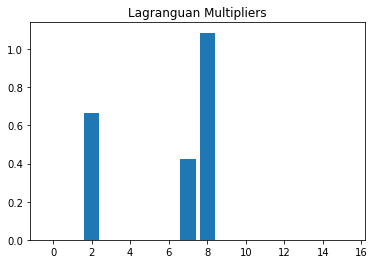

Points are (array([2, 7, 8], dtype=int64),)


In [7]:
# Lagrangian Multipliers
_l_muls = np.array([constraints[i].dual_value for i in range(N)])
_l_muls = _l_muls.flatten()
plt.bar(np.arange(N), _l_muls)
plt.title("Lagranguan Multipliers")
plt.show()
p = np.where(_l_muls > 1e-2)
print(f"Points are {p}")

In the next cell please plot only the support vectors along with the boundary, w vector, and margins. 

**Note: You are not supposed to hard-code the points here.**

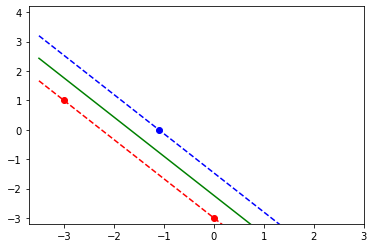

In [8]:
# Write your code here
plot_points(X[p, :][0], y[p])
svm_db(x_min, x_max, y_min, y_max)
plt.show()

In the next cell add the following points:
* (-4, -10) with label 1
* (4, 4) with label -1

Is the decision boundary changed after adding the points? Explain your observations theoretically.

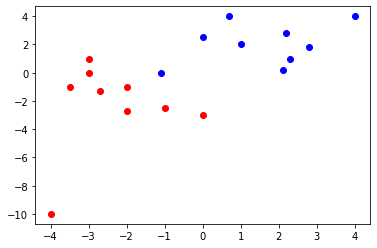

In [9]:
# Re-create the Synthetic Data by adding the points and visualize
X_a = np.vstack((X, np.array([[-4, -10], [4, 4]]))) # X
y_a = np.hstack((y, np.array([1, -1])))     # y
plot_points(X_a, y_a)

Find the SVM for new data

In [10]:
# New decision boundary
N, d = X_a.shape
w = cp.Variable(d)
b = cp.Variable(1)
# All constraints (for all points)
constraints = [y_a[i] * (w.T @ X_a[i, :] - b) >= 1 for i in range(N)]
obj = cp.Minimize(cp.norm(w))   # Minimize the norm of w
prob = cp.Problem(obj, constraints) # Define problem
result = prob.solve()   # Solve for w and b
print(f"w: {w.value}, b: {b.value}")

w: [-1.73913044 -1.30434783], b: [2.91304348]


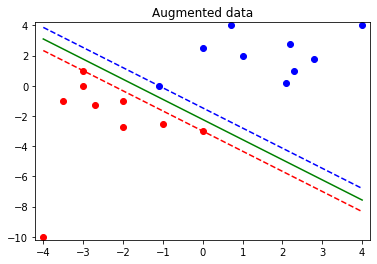

In [11]:
# Show data
plot_points(X_a, y_a)
plt.title("Augmented data")
# Show the decision boundary
x_min = float(np.min(X_a[:, 0]))
x_max = float(np.max(X_a[:, 0]))
y_min = float(np.min(X_a[:, 1]))
y_max = float(np.max(X_a[:, 1]))
svm_db(x_min, x_max, y_min, y_max, w, b)

**Explanation**

The decision boundary, as well as the support vectors, are unchanged. This is because the data-points added are in the correct side of the margins (the new red point is in the red region and the blue one is in the blue region), and are very far from the margins to affect the margins in any way. Hence, since these aren't changing the support vectors, the decision boundary is not changed.

See the proof through support vectors


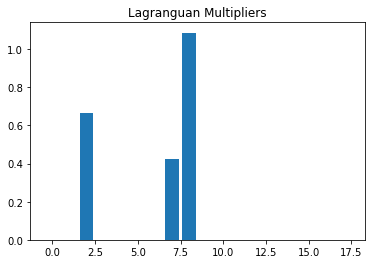

Points are (array([2, 7, 8], dtype=int64),)


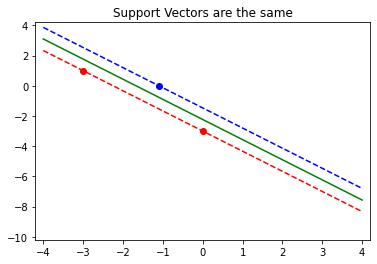

In [12]:
# Lagrangian Multipliers
_l_muls = np.array([constraints[i].dual_value for i in range(N)])
_l_muls = _l_muls.flatten()
plt.bar(np.arange(N), _l_muls)
plt.title("Lagranguan Multipliers")
plt.show()
p = np.where(_l_muls > 1e-2)
print(f"Points are {p}")
# Write your code here
plt.title("Support Vectors are the same")
plot_points(X_a[p, :][0], y_a[p])
svm_db(x_min, x_max, y_min, y_max)
plt.show()

### Support Vector Classifier

A Support Vector Classifier has _softer_ margins (relaxation on the hard constraint rule). This is helpful if there are outliers that either reduce the margins significantly (like we have here), or when the outliers make the data linearly non-separable.


In the next cell you are required to modify your framing of optimisation problem to incorporate soft constraints also known as slack. Plot the decision boundary, w and margin lines for various values of C: $0.01$, $0.1$, $3$, $10$, $100$.

Explain your results theoretically. How does the boundary change with varying values of C? Why?

**Note: Use the modified X and y i.e after adding points in previous cell.**

**Explanation**

Borrowing the hard constraints from the Maximum Margin Classifier explanation

$$
\mathbf{w}^\top \mathbf{x}_i - b \ge 1 \; \textup{if} \; y_i = 1 \qquad
\mathbf{w}^\top \mathbf{x}_i - b \le -1 \; \textup{if} \; y_i = -1
$$

We apply a relaxation to each sample (that is optimized), so that it can avoid this hard bound rule. Specifically, we do

$$
\mathbf{w}^\top \mathbf{x}_i - b \ge 1 - \epsilon_i \; \textup{if} \; y_i = 1 \qquad
\mathbf{w}^\top \mathbf{x}_i - b \le -1 + \epsilon_i \; \textup{if} \; y_i = -1
$$

We can write this as

$$ y_i \left ( \mathbf{w}^\top \mathbf{x}_i - b \right ) \ge 1 - \epsilon_i $$

Note that it doesn't make sense for any $\epsilon$ to be negative (it'll only make the already hard decision rule even harder). The job of $\epsilon$ is to allow a relaxation (give the sample some _slack_). This relaxation allows a less hard correct classification ($0 \lt \epsilon_i \lt 1$) or even a misclassification ($\epsilon_i \gt 1$) for the data-point $\mathbf{x}_i$. So the second constraint is $\epsilon_i \ge 0$ (we'll keep zero for just in case the hard classifier is possible).

Even if we want _some_ slack, we want to _minimize_ the collective slack on the whole dataset. This could be added to the minimization (of $\left \| \mathbf{w} \right \|$) objective. It might as well have some weight given by $C$ (a constant hyper-parameter of sorts, that decides how hard should this constraint be).

Therefore, the new problem is: _Minimize_ $\left \| \mathbf{w} \right \| + C \sum_{i}^N \epsilon_i$ under the constraints $y_i \left ( \mathbf{w}^\top \mathbf{x}_i - b \right ) \ge 1 - \epsilon_i$ _and_ $\epsilon_i \ge 0$

In [13]:
# Generic Support Vector Classifier
def fit_svc(X_d, y_d, C):
    """
        Fits a Support Vector Classifier and returns the parameters.
        The SVC equation is: w.T @ x_i - b = 0 (decision boundary),
        = +1 or -1 (for margins).

        Paraemters:
        - X_d: np.ndarray   shape: N, d
            Input data
        - y_d: np.ndarray   shape: N, 1
            Expected labels (+1 or -1 elements only)
        
        Returns:
        - w: cvxpy.Variable     shape: d,
            Weights for the decision boundary
        - b: cvxpy.Variable     shape: 1
            Bias for the decision boundary
        - ep: cvxpy.Variable    shape: N,
            The slackness for each data-point
        - _lm: np.ndarray       shape: N,
            A vector of lagrangian multipliers (for support vector)
    """
    N, d = X_d.shape
    w = cp.Variable(d)
    b = cp.Variable(1)
    ep = cp.Variable(N)
    # Constraints
    constraints1 = [y_d[i] * (w.T @ X_d[i, :] - b) >= 1 - ep[i] \
        for i in range(N)]
    constraints2 = [ep[i] >= 0 for i in range(N)]
    constraints = constraints1 + constraints2
    # Objective
    obj = cp.Minimize(cp.norm(w) + C*cp.sum(ep))
    # Main problem
    prob = cp.Problem(obj, constraints)
    # Result
    result = prob.solve()
    _lm = np.array([constraints[i].dual_value for i in range(N)])
    return w, b, ep, _lm

Decision Boundary: w = [-2.87436094e-11 -2.43864457e-11], b = [-0.06781041]


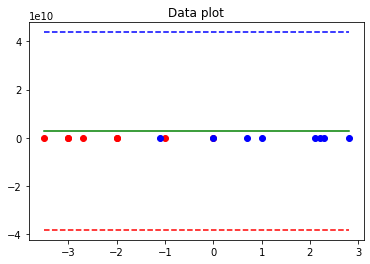

Sum of epsilon: 16.000000006367827


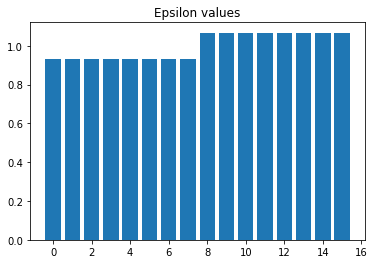

In [14]:
# Write your code here for C= 0.01
w, b, ep, _ = fit_svc(X, y, 0.01)
print(f"Decision Boundary: w = {w.value}, b = {b.value}")
plt.title("Data plot")
plot_points(X, y)
# Show the decision boundary
x_min = float(np.min(X[:, 0]))
x_max = float(np.max(X[:, 0]))
y_min = float(np.min(X[:, 1]))
y_max = float(np.max(X[:, 1]))
# Red: +1, Blue: -1, Green: 0 (decision boundary)
svm_db(x_min, x_max, y_min, y_max, w, b, False)
plt.show()
print(f"Sum of epsilon: {np.sum(ep.value)}")
plt.title("Epsilon values")
plt.bar(np.arange(X.shape[0]), ep.value)
plt.show()

Sum of epsilon: 2.191228308695981


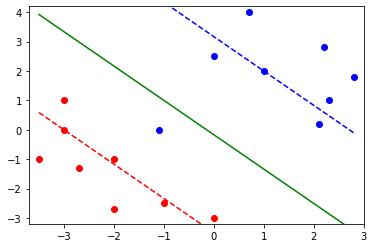

In [15]:
# Write your code here for C= 0.1
w, b, ep, _ = fit_svc(X, y, 0.1)
print(f"Sum of epsilon: {np.sum(ep.value)}")
plot_points(X, y)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()

Sum of epsilon: 1.4424242418781403


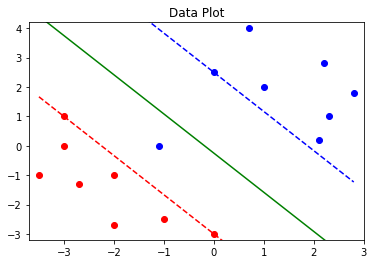

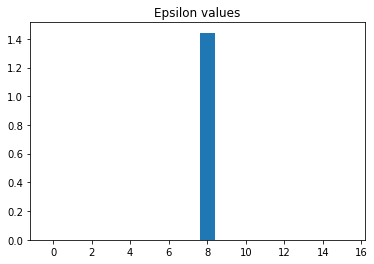

In [16]:
# Write your code here for C= 1
w, b, ep, _ = fit_svc(X, y, 1)
print(f"Sum of epsilon: {np.sum(ep.value)}")
plt.title("Data Plot")
plot_points(X, y)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()
# Epsilon plot
plt.title("Epsilon values")
plt.bar(np.arange(X.shape[0]), ep.value)
plt.show()

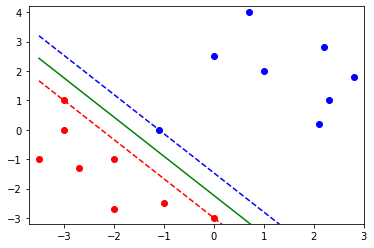

In [17]:
# Write your code here for C= 3
w, b, ep, _ = fit_svc(X, y, 3)
plot_points(X, y)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()

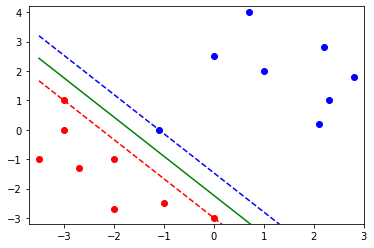

In [18]:
# Write your code here for C= 10
w, b, ep, _ = fit_svc(X, y, 10)
plot_points(X, y)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()

Sum of epsilon: -3.524420745617763e-11


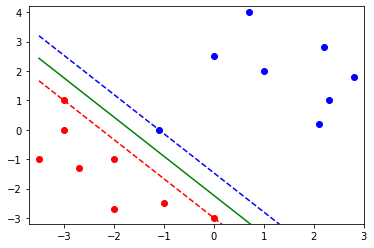

Support Vectors are (indices): [2 7 8]
X: [[-3.   1. ]
 [ 0.  -3. ]
 [-1.1  0. ]] 
Y: [ 1  1 -1]


In [19]:
# Write your code here for C= 100
w, b, ep, c = fit_svc(X, y, 100)
print(f"Sum of epsilon: {np.sum(ep.value)}")
plot_points(X, y)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()
# Support Vectors
svecs = np.where(c > 1e-2)[0]
print(f"Support Vectors are (indices): {svecs}")
print(f"X: {X[svecs, :]} \nY: {y[svecs]}")

Take the case of C = 100 and remove the support vectors. Does the boundary change after the deletion?
Explain why? Show your results by appropriate plots?

Sum of epsilon: -5.753321727774408e-12


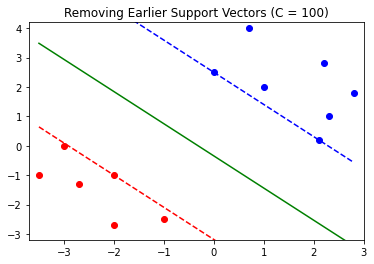

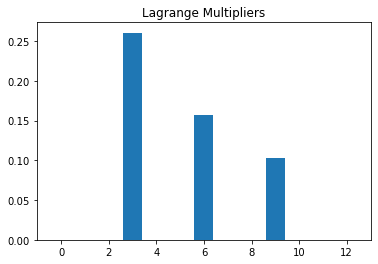

Support Vectors are (indices): [3 6 9]
X: [[-2.  -1. ]
 [ 0.   2.5]
 [ 2.1  0.2]] 
Y: [ 1 -1 -1]


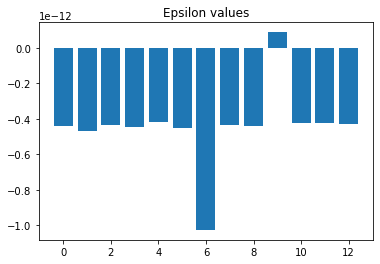

In [20]:
# Write your Code here
X_a, y_a = np.delete(X, svecs, axis=0), np.delete(y, svecs)
w, b, ep, lm = fit_svc(X_a, y_a, 100)
print(f"Sum of epsilon: {np.sum(ep.value)}")
# Show everything
plt.title("Removing Earlier Support Vectors (C = 100)")
plot_points(X_a, y_a)
svm_db(x_min, x_max, y_min, y_max, w, b)
plt.show()
# Epsilon plot
plt.title("Lagrange Multipliers")
plt.bar(np.arange(X_a.shape[0]), lm.flatten())
plt.show()
# Support Vectors
svecs = np.where(lm > 1e-2)[0]
print(f"Support Vectors are (indices): {svecs}")
print(f"X: {X_a[svecs, :]} \nY: {y_a[svecs]}")
# Epsilon values
plt.title("Epsilon values")
plt.bar(np.arange(X_a.shape[0]), ep.value)
plt.show()

As expected, setting a very high $C$ value enforces the algorithm's _hardness_ of the decision boundary. In the above plots, $C=1$ probably gives the best plot (with only the 8th datapoint being considered an exception). As we increase $C$, the decision boundary turns more and more hard, because the minimization of sum of $\epsilon_i$ is being chased more and more aggressively. It can be seen that the sum of epsilon decreases as $C$ increases.

Therefore, $C$ can be said to be a regularization parameter. When it was 0.01, the SVC learned pretty much nothing; when it was 1, the SVC probably fit the data best; when it was 10 (or 100), the SVC was the same as the maximum margin classifier (the sum of epsilon is nearly zero). Therefore, the strength of regularization is inversely proportional to C.

**Removing support vectors** with C = 100

When the support vectors were removed, the optimization process simply chose newer support vectors. Since the next support vectors were very far, the decision boundary looks very good (high margins). They happen to be approximately close to the result we got when C = 1 (but that was a better, _regularized_ result as it didn't require data deletion). The lagrangian multiplier plot clearly shows the new support vectors. Note that the tolerance, slack or sum of epsilon values is still very strict (almost zero), so it's a hard classifier (with all $\epsilon_i$ values approximately 0, note the scale of `1e-11` for the epsilon bar plot).

## Subsection 2

The following commands were run on Windows PowerShell to download the datasets

```pwsh
mkdir ./samples/
cd samples/
Invoke-WebRequest -Uri http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz -OutFile train-images-idx3-ubyte.gz
Invoke-WebRequest -Uri http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz -OutFile train-labels-idx1-ubyte.gz
Invoke-WebRequest -Uri http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz -OutFile t10k-images-idx3-ubyte.gz
Invoke-WebRequest -Uri http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz -OutFile t10k-labels-idx1-ubyte.gz
```

They were then extracted using [WinRAR](https://www.win-rar.com/start.html?&L=0). Then `python-mnist` was installed by running

```pwsh
pip install python-mnist
```

The extracted files had to be renamed to replace the `.` with `-` (for the `python-mnist` library to read the ubyte files).

In [21]:
# Import Relevant Packages
from sklearn.svm import SVC
import numpy as np
from mnist.loader import MNIST

In [22]:
mndata = MNIST('samples')

# Load training dataset
images, labels = mndata.load_training()
l = len(labels)
images_train = np.array(images)
labels_train = np.array(labels)

print(images_train.shape)
print(labels_train.shape)

(60000, 784)
(60000,)


In [23]:
# Load testing dataset
images, labels = mndata.load_testing()
l = len(labels)
images_test = np.array(images)
labels_test = np.array(labels)

print(images_test.shape)
print(labels_test.shape)

(10000, 784)
(10000,)


- Tweak different parameters like the C Parameter and gamma parameter of the Linear SVM and report the results.
- Experiment different kernels for classification and report the results.

Report accuracy score, F1-score, Confusion matrix and any other metrics you feel useful.

> **Remarks**: It takes around 5 minutes to train (execution time for the training cells that call `fit` on the dataset) and around 1 minute to test (execution time for the testing all data)

### Session 1: Defaults

Testing the default Support Vector Classifier with `C = 1.0` (default), Radial Basis Function kernel (it can project data into [infinite dimensions](https://www.youtube.com/watch?v=Qc5IyLW_hns) because of the exponential term; think of taylor expansion of exponential) and scaling gamma is used.

**Reference**: [SVC Class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

In [24]:
# Classifier (test 1)
clf = SVC(C=1.0)
clf.fit(images_train, labels_train)

SVC()

#### Metrics

Different metrics (and references for them)

- [Accuracy score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): Percentage of correctly classified items.
- [F1-score](https://en.wikipedia.org/wiki/F-score#Definition): Harmonic mean of precision and recall. Precision is true positive divided by sum of true positive and false positive (fraction of positively retrieved that are relevant). Recall is true positive divided by sum of true positive and false negatives (fraction of relevant items retrieved).
- [Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html): A square matrix where the $i, j$ element is the number of elements in group $i$, predicted to be in group $j$. Best displayed as an image.

In [25]:
# Imports
from sklearn.metrics import accuracy_score, f1_score
# Confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [26]:
# Accuracy Score
pred_test = clf.predict(images_test)
acc = accuracy_score(labels_test, pred_test)
print(f"Accuracy score is: {acc*100} %")

Accuracy score is: 97.92 %


In [27]:
# F1 Score (labels are sorted)
f1_sc = f1_score(labels_test, pred_test, average=None)
print(f"F1-Score is (0 to 9 - digits): \n{f1_sc}")

F1-Score is (0 to 9 - digits): 
[0.98631526 0.99032542 0.97527872 0.9798129  0.98061224 0.98140845
 0.98538622 0.97218155 0.97336066 0.96661684]


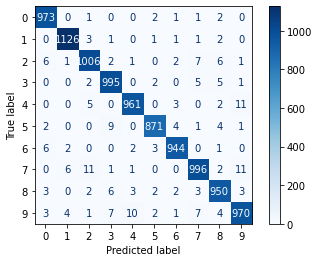

In [28]:
# Confusion Matrix (10 by 10 matrix)
ConfusionMatrixDisplay.from_predictions(labels_test, pred_test, 
    cmap='Blues')
plt.show()

As seen above, the default RBF kernel SVM performs very good on the MNIST dataset. Let's test a modification where we limit the projection space by choosing a different kernel.

### Session 2: First Degree Polynomial

A first degree polynomial kernel (basically a linear decision boundary) will limit the projection space (plain features, no extra powers). Used `poly` with degree 1 instead of `linear` because it was found to be more computationally efficient. Let us increase `C` (3 for example) to see if it really overfits the training set using this. We can let other parameters be the default values.

**Reference**: [Different SVM Kernels in Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#svm-kernels)


In [29]:
# Classifier (test 2)
clf_2 = SVC(C=3.0, kernel='poly', degree=1)
clf_2.fit(images_train, labels_train)

SVC(C=3.0, degree=1, kernel='poly')

#### Metrics

Visualizing the same metrics as we did in Session 1

In [30]:
# Accuracy Score
pred_test_2 = clf_2.predict(images_test)
acc_2 = accuracy_score(labels_test, pred_test_2)
print(f"Accuracy score is: {acc_2*100} %")

Accuracy score is: 94.64 %


In [31]:
# F1 Score (labels are sorted)
f1_sc_2 = f1_score(labels_test, pred_test_2, average=None)
print(f"F1-Score is (0 to 9 - digits): \n{f1_sc_2}")

F1-Score is (0 to 9 - digits): 
[0.97433317 0.98250219 0.9385583  0.92871094 0.94964753 0.90939977
 0.96346555 0.94690265 0.92540428 0.93627697]


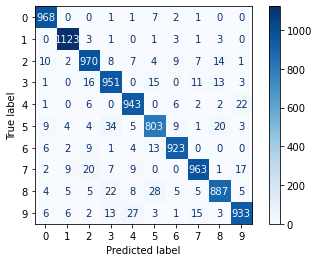

In [32]:
# Confusion Matrix (10 by 10 matrix)
ConfusionMatrixDisplay.from_predictions(labels_test, pred_test_2, 
    cmap='Blues')
plt.show()

### Remarks

- As the complexity of kernel decreases, so does the variance. It could decrease so much that it shows with lesser accuracy.
    - This decrease in accuracy is visible across all indicators. It has lesser F1-score for all labels, the confusion matrix shows more misclassifications (most of the off-diagonal terms do not remain zero)
- As the `C` value increases, the model tends to either overfit the training set by learning a hard decision boundary. This decreases performance during testing.